In [23]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math as math
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

In [24]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [25]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [26]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [27]:
#! unzip ../input/training-data-final

In [28]:
#import zipfile as zf

#files = zf.ZipFile("training_dataset_homework1.zip",'r')
#files.extractall()
#files.close()

In [29]:
# Dataset folders 
dataset_dir = '/kaggle/input/flippeddataset2/training_data_final_divided_and_flipped2'
training_dir  = os.path.join(dataset_dir, 'Training')
validation_dir = os.path.join(dataset_dir, 'Validation')
#test_dir = os.path.join(dataset_dir, 'test')


In [30]:
def step_decay(epoch):

   initial_lrate = 0.01
   drop = 0.1
   epochs_drop = 5 

   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))

   return lrate

In [31]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
               
  callbacks.append(es_callback)

  # reduce learning rate on plateau

  plat_callbacks=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)
  
  callbacks.append(plat_callbacks)           

  return callbacks

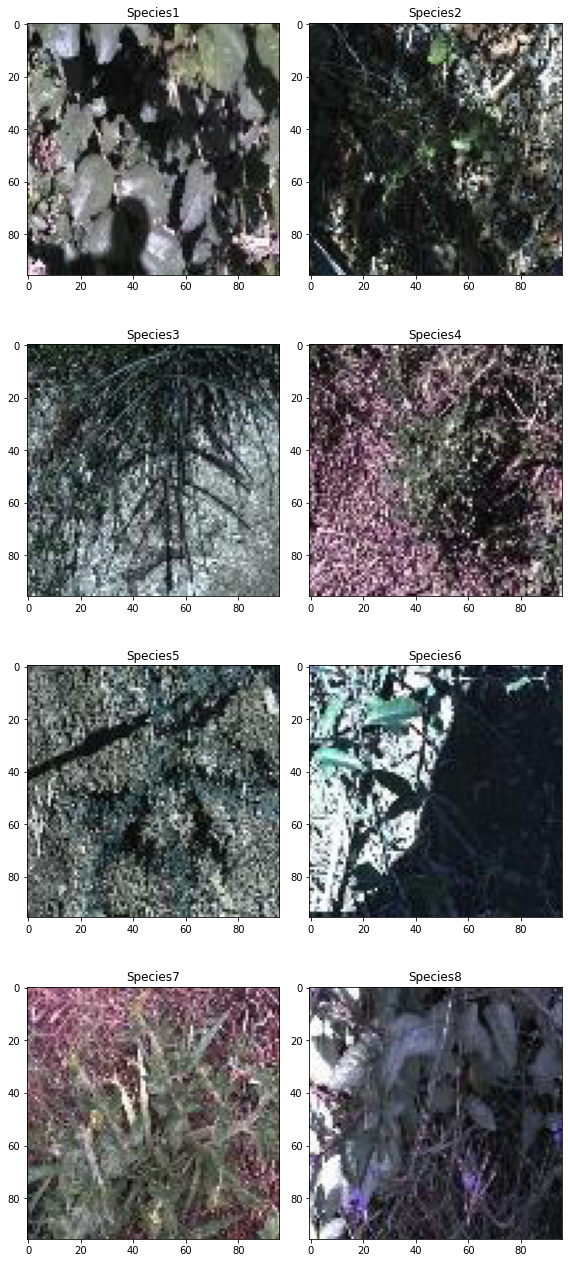

In [32]:
# Plot example images from dataset
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8',       # 7
          ]  
 

num_row = len(labels) // 2
num_col = len(labels) // num_row

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}//{}/'.format(training_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}//{}/{}'.format(training_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [33]:
class_weights = {
    0 : 1/186,
    1 : 1/532,
    2 : 1/515,
    3 : 1/511,
    4 : 1/531,
    5 : 1/222,
    6 : 1/537,
    7 : 1/508
}

In [34]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input


# Create an instance of ImageDataGenerator
aug_image_generator3=ImageDataGenerator(rotation_range= 45,
                                       height_shift_range = 0.3,
                                       width_shift_range = 0.3,
                                       zoom_range = 0.4,
                                       vertical_flip = True, 
                                       fill_mode='reflect',
                                       brightness_range=(0.2,1.2),
                                       rescale=1/255.)#,
                                       #preprocessing_function=preprocess_input)

#image_generator3=ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255.)

image_generator3=ImageDataGenerator(rescale=1/255.)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen3 = aug_image_generator3.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=True,
                                               seed=seed)
valid_gen3 = image_generator3.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 6382 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [35]:
from collections import Counter

counter = Counter(aug_train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}          

class_weights

{0: 2.880952380952381,
 1: 1.010438413361169,
 2: 1.043103448275862,
 3: 1.0521739130434782,
 4: 1.0125523012552302,
 5: 2.42,
 6: 1.0,
 7: 1.056768558951965}

In [36]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    conv1 = tfkl.BatchNormalization()(conv1)
    
    leaky_relu_layer1 = tfkl.LeakyReLU()(conv1)
    
    pool1 = tfkl.MaxPooling2D(pool_size = (2, 2))(leaky_relu_layer1)
    
    
    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    conv2 = tfkl.BatchNormalization()(conv2)
    
    leaky_relu_layer2 = tfkl.LeakyReLU()(conv2)
    
    pool2 = tfkl.MaxPooling2D(pool_size = (2, 2))(leaky_relu_layer2)
    
    

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    conv3 = tfkl.BatchNormalization()(conv3)
    
    leaky_relu_layer3 = tfkl.LeakyReLU()(conv3)
    
    pool3 = tfkl.MaxPooling2D(pool_size = (2, 2))(leaky_relu_layer3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    conv4 = tfkl.BatchNormalization()(conv4)
    
    leaky_relu_layer4 = tfkl.LeakyReLU()(conv4)
    
    pool4 = tfkl.MaxPooling2D(pool_size = (2, 2))(leaky_relu_layer4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    conv5 = tfkl.BatchNormalization()(conv5)
    
    leaky_relu_layer5 = tfkl.LeakyReLU()(conv5)
    
    pool5 = tfkl.MaxPooling2D(pool_size = (2, 2))(leaky_relu_layer5)

    #flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(pool5)


    classifier_layer = tfkl.Dense(
        units=512, 
        name='Classifier', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(glob_pooling)

    classifier_layer = tfkl.BatchNormalization()(classifier_layer)
    
    leaky_relu_layer = tfkl.LeakyReLU()(classifier_layer)
    
    leaky_relu_layer = tfkl.Dropout(0.2, seed=seed)(leaky_relu_layer)
    
    classifier_layer2 = tfkl.Dense(
        units=256, 
        name='Classifier2',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(classifier_layer)
        
    classifier_layer2 = tfkl.BatchNormalization()(classifier_layer2)
    
    leaky_relu_layer2 = tfkl.LeakyReLU()(classifier_layer2)
    
    leaky_relu_layer2 = tfkl.Dropout(0.3, seed=seed)(leaky_relu_layer2)
    
    output_layer = tfkl.Dense(
        units=8, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics='accuracy')

    # Return the model
    return model

In [37]:
input_shape = (96, 96, 3)
epochs = 200
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256   

In [38]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='model')

# Train the model
history = model.fit(
    x = aug_train_gen3,
    epochs = 200,
    batch_size=64,
    validation_data = valid_gen3,
    callbacks = aug_callbacks,
    class_weight=class_weights,
).history

    # callbacks = aug_callbacks
    # class_weight=class_weights,
    #     class_weight=class_weights
    # callbacks = None
    # [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]

Epoch 1/200
399/399 [==============================] - 26s 63ms/step - loss: 2.3292 - accuracy: 0.2809 - val_loss: 2.8711 - val_accuracy: 0.2279
Epoch 2/200
399/399 [==============================] - 25s 64ms/step - loss: 2.1835 - accuracy: 0.3386 - val_loss: 2.5432 - val_accuracy: 0.1994
Epoch 3/200
399/399 [==============================] - 26s 65ms/step - loss: 2.0820 - accuracy: 0.3524 - val_loss: 1.9478 - val_accuracy: 0.3219
Epoch 4/200
399/399 [==============================] - 26s 65ms/step - loss: 2.0059 - accuracy: 0.3928 - val_loss: 2.5406 - val_accuracy: 0.3077
Epoch 5/200
399/399 [==============================] - 25s 63ms/step - loss: 1.9210 - accuracy: 0.4372 - val_loss: 2.7267 - val_accuracy: 0.1795
Epoch 6/200
399/399 [==============================] - 26s 64ms/step - loss: 1.8023 - accuracy: 0.4709 - val_loss: 1.5620 - val_accuracy: 0.4359
Epoch 7/200
399/399 [==============================] - 26s 65ms/step - loss: 1.7678 - accuracy: 0.4768 - val_loss: 1.6311 - val_ac

In [39]:
model.save('cnnNoPreProcessFixedDataAugmentation2')

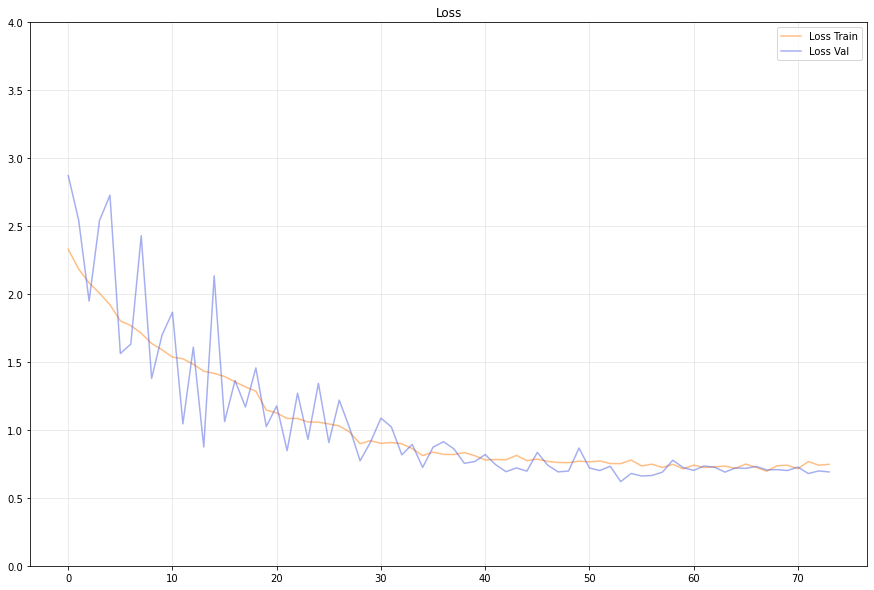

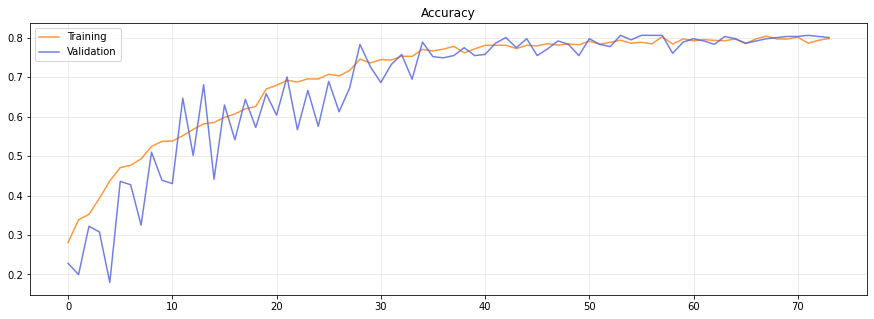

In [40]:
# Loss Graph
ALPHA = 0.5

plt.figure(figsize=(15,10))

plt.plot(history['loss'], label='Loss Train', alpha=ALPHA, color='#ff7f0e')
plt.plot(history['val_loss'], label='Loss Val', alpha=ALPHA, color='#4D61E2')

plt.ylim(0, 4)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [41]:
#model = tf.keras.models.load_model('/kaggle/input/firstattempt/CNN_200_epochs_aug_callbacks')


In [42]:
def get_next_batch(generator):
    return next(generator)

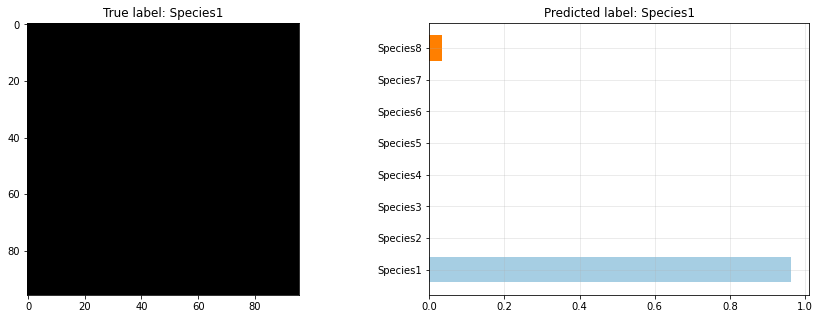

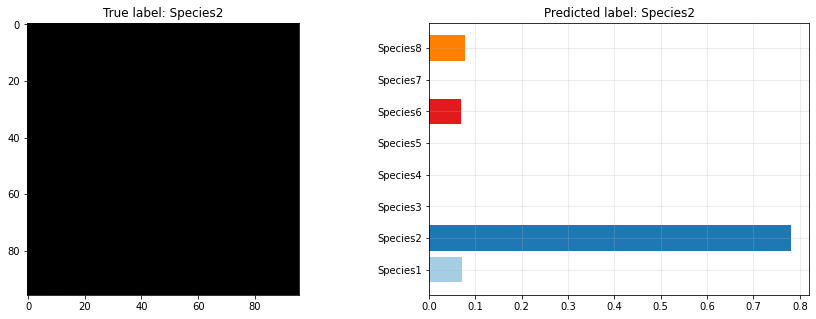

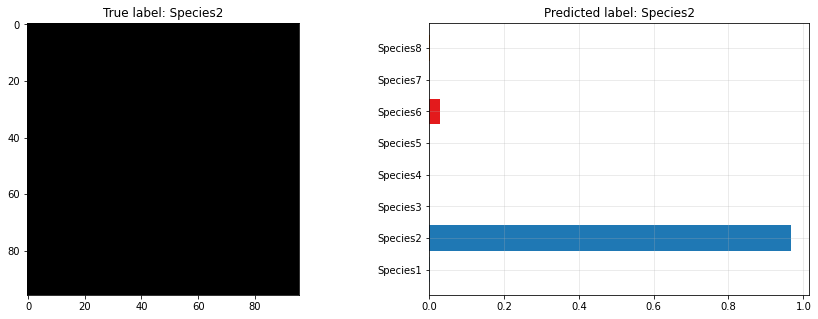

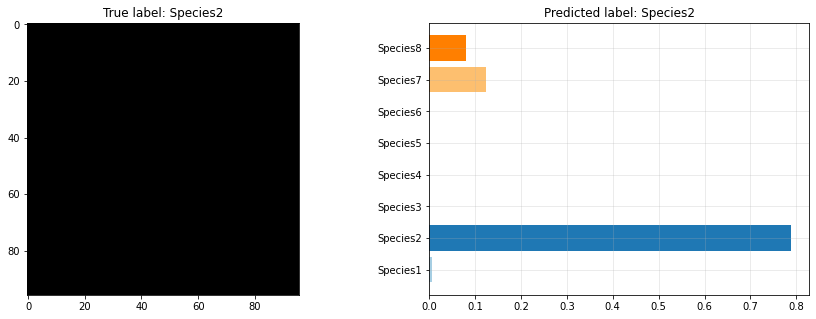

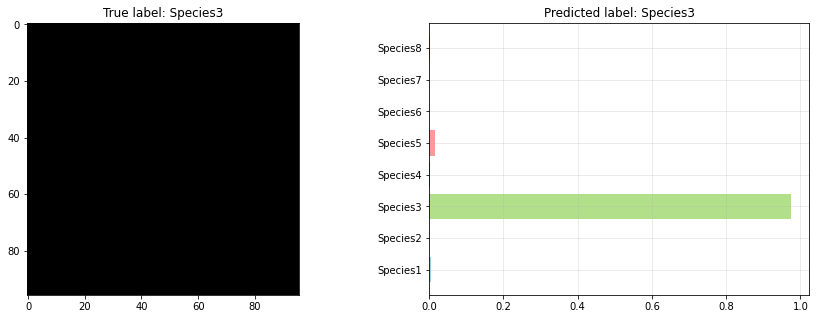

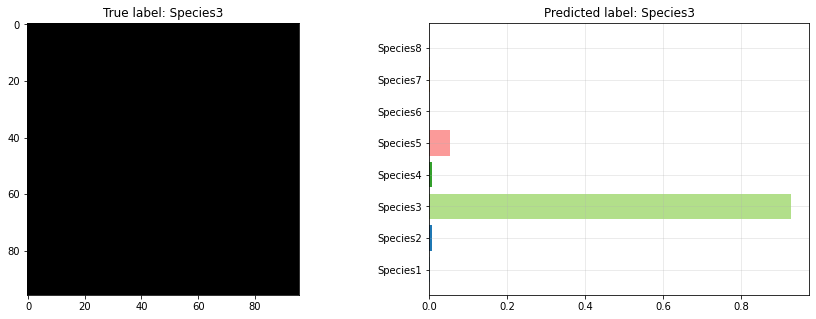

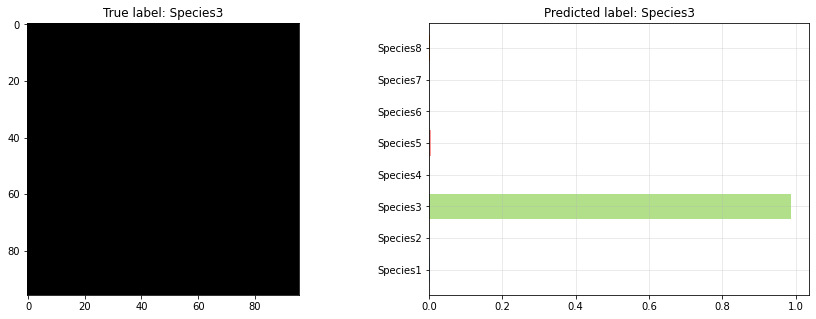

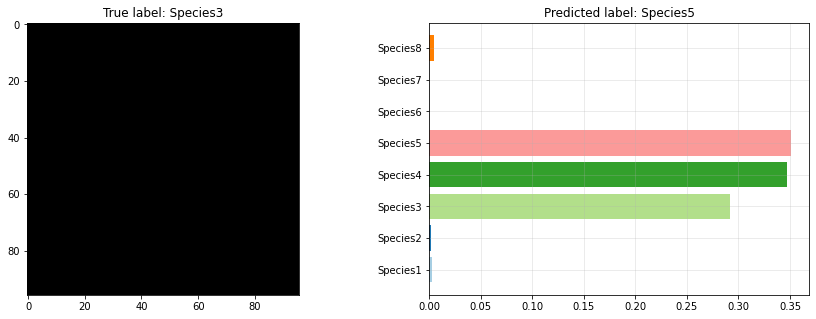

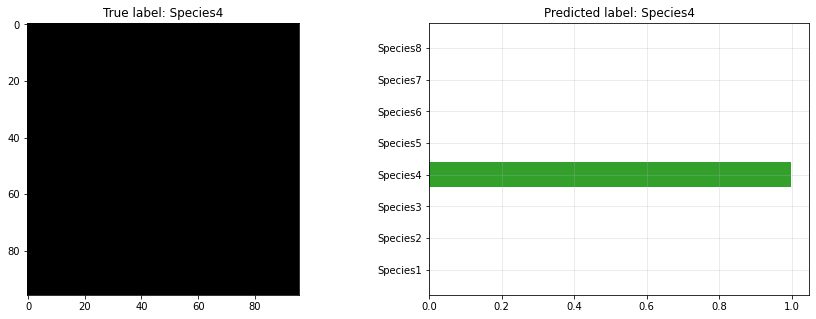

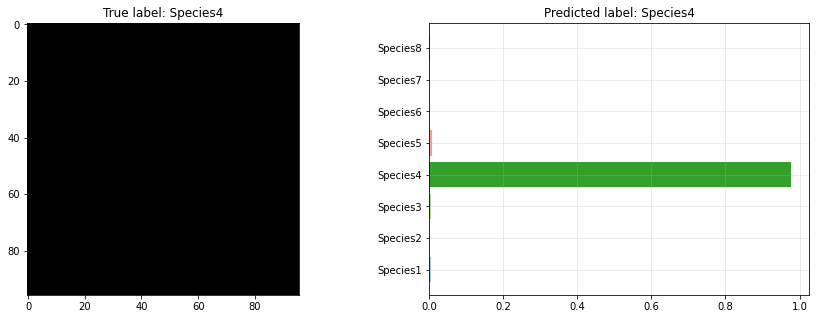

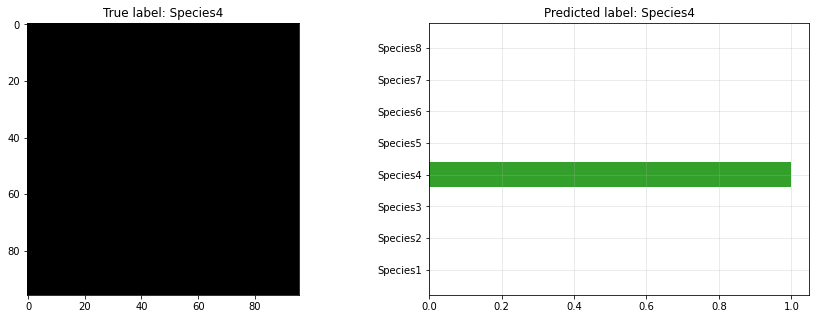

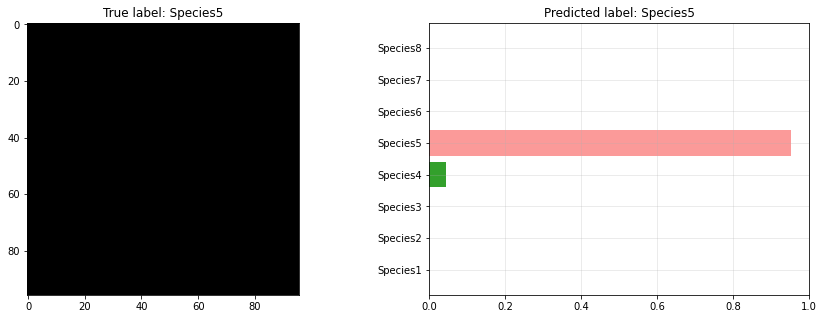

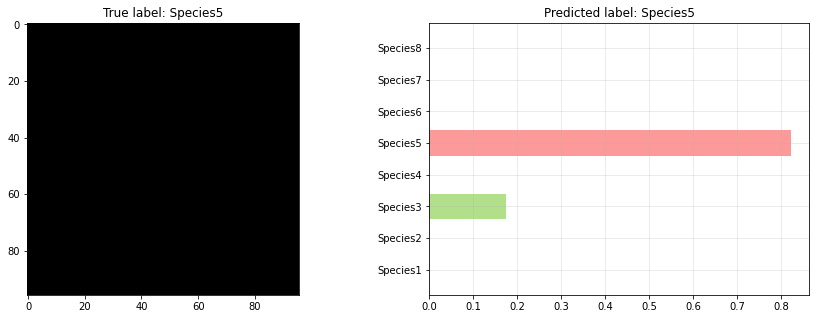

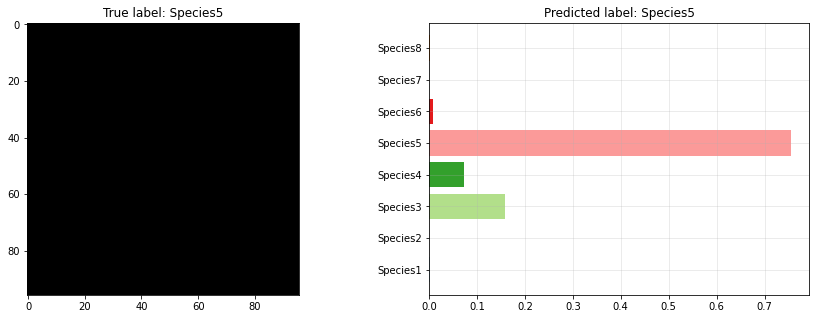

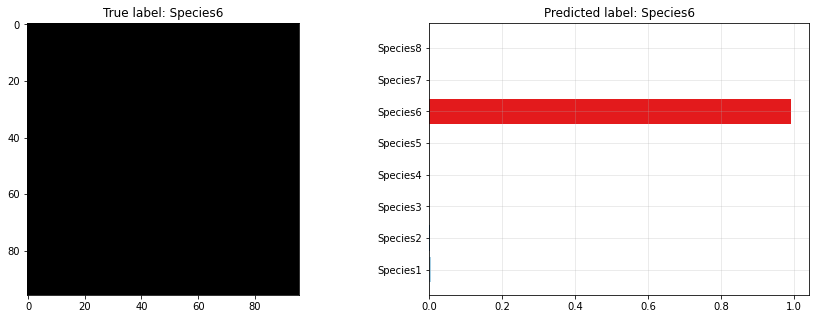

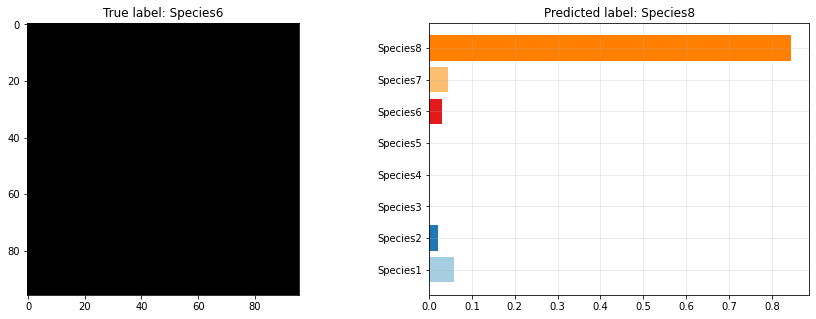

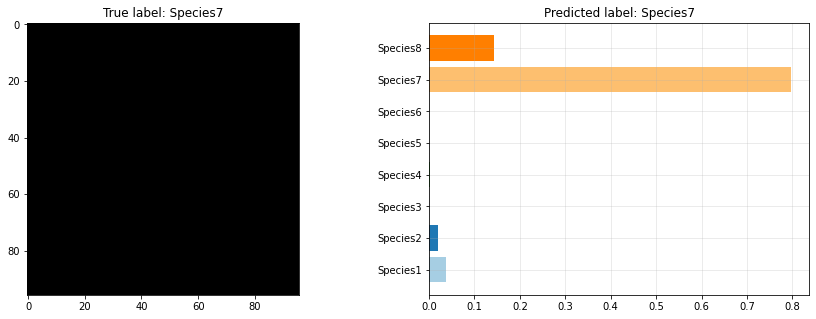

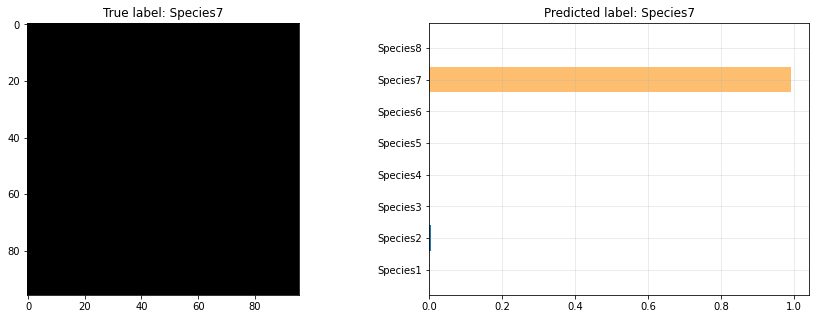

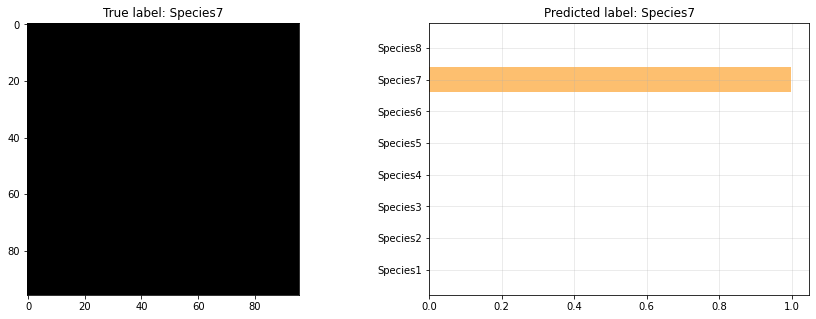

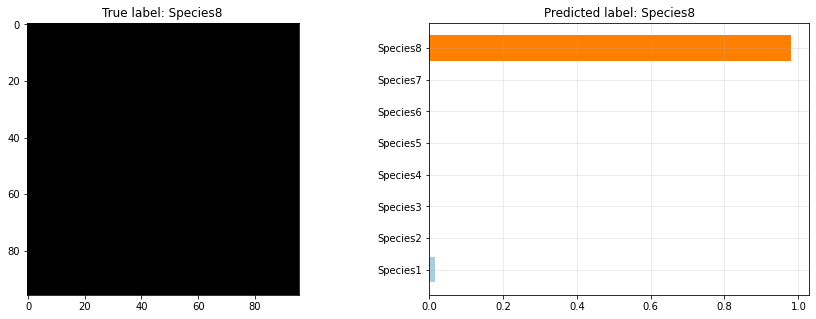

In [43]:
for i in range(0,20):
    batch = get_next_batch(valid_gen3)

    choosen_pos = 7

    predictions = model.predict(batch[0])
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    ax1.imshow(np.uint8(batch[0][choosen_pos]))
    ax1.set_title('True label: '+ labels[np.argmax(batch[-1][choosen_pos])])
    ax2.barh(list(labels), predictions[choosen_pos], color=plt.get_cmap('Paired').colors)
    ax2.set_title('Predicted label: '+labels[np.argmax(predictions[choosen_pos])])
    ax2.grid(alpha=.3)
    plt.show()

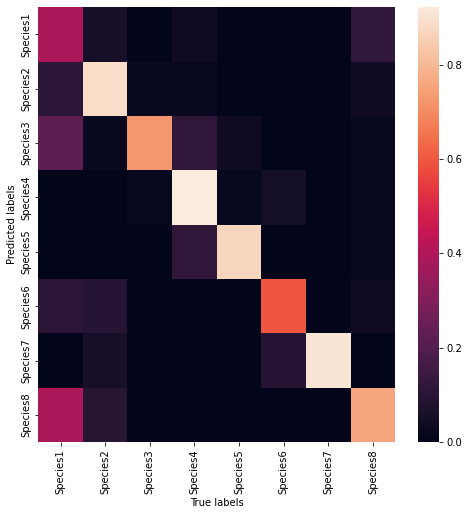

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
true_label = batch[1]
pred_label = model.predict(batch[0])
for i in range(0,500):
    batch = get_next_batch(valid_gen3)
    true_label = np.concatenate((true_label, batch[1]), axis=0)
    pred_label = np.concatenate((pred_label, model.predict(batch[0])), axis=0)
#%%
#confusion matrix
cm = confusion_matrix(np.argmax(true_label, axis=-1), np.argmax(pred_label, axis=-1))
# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm/sum(true_label), xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()